# Kvadratur-metodar

## Adaptiv Simpson-kvadratur

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# pretty-print sympy things
sp.init_printing()

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'font.family': "serif",
    'text.usetex': True,
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        r"\setmainfont{EB Garamond}",
        r"\setmonofont{Courier New}",
        r"\setmathfont{Garamond-Math}",
    ],
    'figure.figsize': (16,9), 
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.
mpl.use('pgf')

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')

# finally change the necessary parameters
plt.rcParams.update(newparams)

In [22]:
def asm_quad(f, a, b, tol=1e-5):

    def S(a, b):
        return abs(b - a) / 6 * (f(a) + 4 * f((a + b) / 2) + f(b))
    
    I_0 = S(a, b)
    c = (a + b) / 2
    
    I = S(a, c) + S(c, b) 
    err = abs(I - I_0) / 15
    
    if err <= tol:
        return I + (I - I_0) / 15
    
    return asm_quad(f, a, c, tol=tol/2) + asm_quad(f, c, b, tol=tol/2)

### Testar

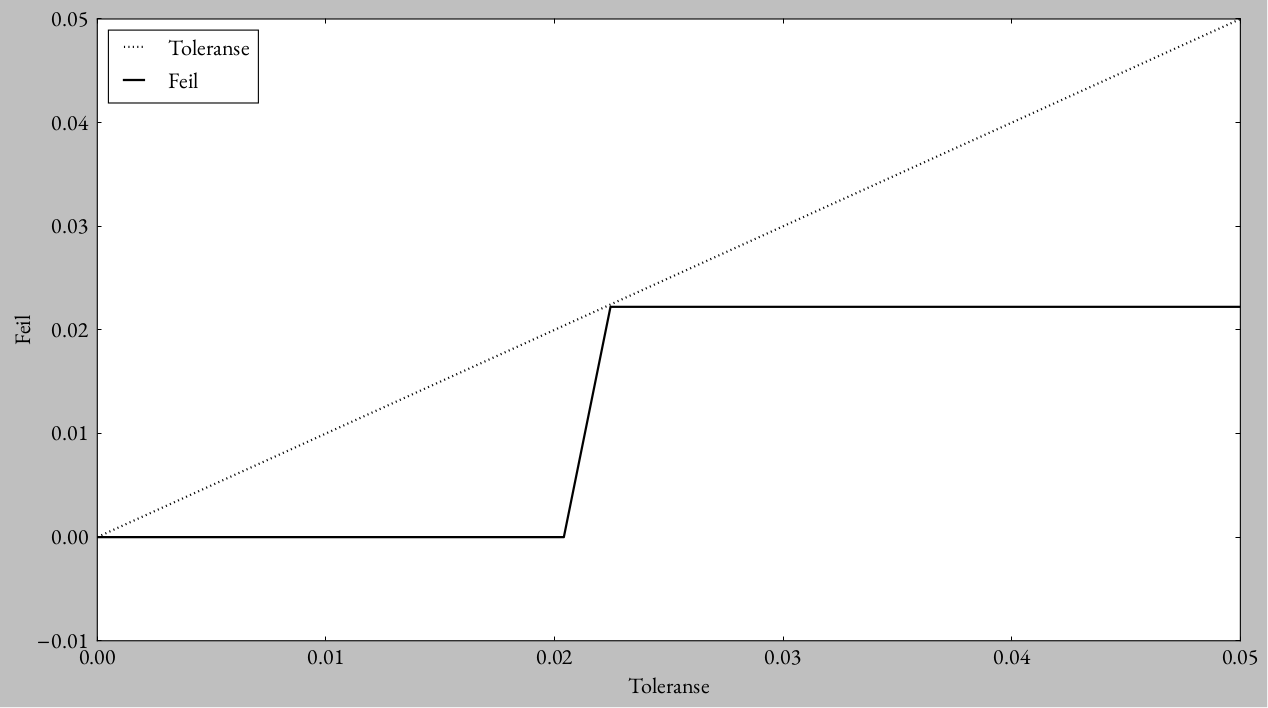

In [46]:
x = sp.symbols('x')
f = sp.cos(2 * sp.pi * x)
F = sp.integrate(f)
# make python function versions
f = sp.lambdify(x, f)
F = sp.lambdify(x, F)

a, b = 0, 1
I = F(b) - F(a) # = 0

tols = np.linspace(1e-10, 1e-1, 50)
errs = np.array([abs(asm_quad(f, a, b, tol=t) - I) for t in tols])

plt.plot(tols, tols, 'k:', label="Toleranse")
plt.plot(tols, errs, 'k', label="Feil")

plt.ylabel("Feil")
plt.xlabel("Toleranse")

plt.xlim(tols[0], tols[-1] / 2)
plt.ylim(-0.01, tols[-1] / 2)
plt.legend(loc="best")

plt.tight_layout()

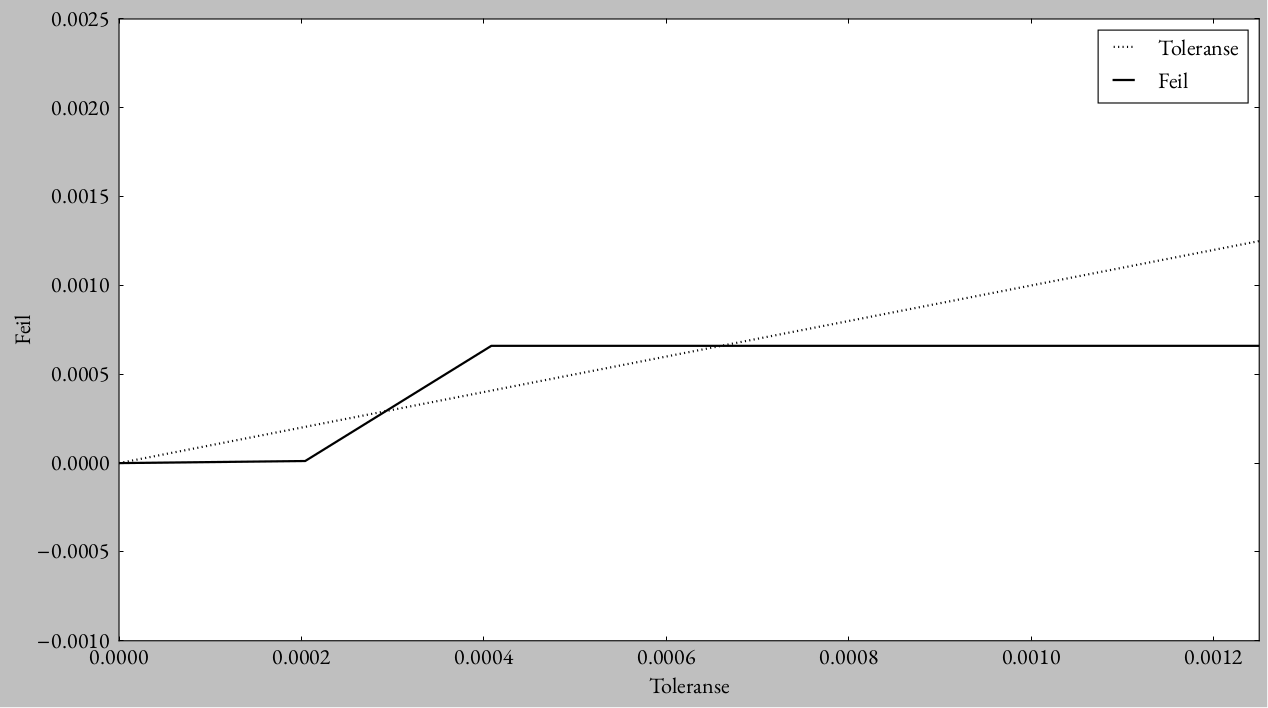

In [48]:
x = sp.symbols('x')
f = sp.exp(3 * x) * sp.sin(2 * x)
F = sp.integrate(f)
# make python function versions
f = sp.lambdify(x, f)
F = sp.lambdify(x, F)

a, b = 0, np.pi/4
I = F(b) - F(a)

tols = np.linspace(1e-10, 1e-2, 50)
errs = np.array([abs(asm_quad(f, a, b, tol=t) - I) for t in tols])

plt.plot(tols, tols, 'k:', label="Toleranse")
plt.plot(tols, errs, 'k', label="Feil")

plt.xlim(tols[0], tols[-1] / 8)
plt.ylim(-0.001, tols[-1] / 4)

plt.ylabel("Feil")
plt.xlabel("Toleranse")

plt.legend(loc="best")
plt.tight_layout()

På eit lite intervall er feilen større enn toleransen.
Eg forsøkte å samanlikne med ein implementasjon frå wikipedia,
og resultatet er nøyaktig det same.

## Romberg-kvadratur

Eg brukar dette trikset for å spare litt minne:

In [10]:
R = np.array([[1, 2, 3], [3, 4, 5]])
Rp, Rn = 0, 1

R[Rn, :] = 9
Rp, Rn = Rn, Rp # (1)
R[Rn, :] = 8
print(R)

[[8 8 8]
 [9 9 9]]


Og lagrar kun to rader i gongen. Vi kan bruke (1)
til å bytte radene. Til eit kvart tidspunkt er
${\tt R[Rn, j]} = R(n, j)$ og ${\tt R[Rp, j]} = R(n - 1, j)$.
Når vi er ferdig med ein iterasjon byttar vi om på "peikarane",
slik at `Rn` blir `Rp`, og skriv over verdiane frå to iterasjonar
tilbake i i staden for å allokere minne for heile matrisa.

In [80]:
def romberg(f, a, b, MAX_ITER=100, tol=1e-5):
    R = np.full(shape = (2, MAX_ITER), fill_value = np.nan)
    Rp, Rn = 0, 1
    
    h = b - a 
    R[Rp, 0] = 0.5 * h * (f(a) + f(b))
    
    for n in range(1, MAX_ITER):
        h = h * 0.5
        L = np.linspace(a + h, b - h, 1 << n - 1)
        R[Rn, 0] = 0.5 * R[Rp, 0] + h * np.sum(f(L))
        
        for k in range(1, n + 1):
            E = (R[Rn, k - 1] - R[Rp, k - 1]) / ((1 << 2 * k) - 1)
            R[Rn, k] = R[Rn, k - 1] + E
                
        Rp, Rn = Rn, Rp
        
        if abs(E) < tol:
            break
    
    return R[Rp, n]

### Test
For å teste algoritma forsøker eg å evaluere gauss-integralet.

In [81]:
def gauss(x): return 2/np.sqrt(np.pi) * np.exp(-x**2)

erf1_exact = 0.842700792949714869341220635082609259296066997966302908459

erf1 = romberg(gauss, 0, 1, tol=1e-16)
erf1, abs(erf1 - erf1_exact)

In [82]:
def f(x): return np.cos(2 * np.pi * x)
def g(x): return x**(1/3)

In [90]:
import time
start = time.time()
a,b = romberg(f, 0, 1, tol=1e-16), romberg(g, 0, 1, tol=1e-16)
end = time.time()
(end - start) * 1000, a, b

In [84]:
start = time.time()
a,b = asm_quad(f, 0, 1, tol=1e-16), asm_quad(g, 0, 1, tol=1e-16)
end = time.time()
(end - start) * 1000, a, b

Romberg-algoritma ser ut til å vere vesentlig raskare,
men adaptiv simpson gir _litt_ meir presise resultat.
Samanlikninga er ikkje heilt rettferdig, ettersom simpson-algoritma er rekursiv,
men kan skrivast iterativt.

Rekursive algoritmer er ofte treige i Python,
fordi allokasjon av stack-rammer (so vidt eg veit) krever dynamisk allokering av
minne til bytecode-vektoren, samanlikna med kompilerte språk der allokasjon av stack-rammer
kunn svarar til å inkrementere ein peikar.

In [107]:
def print_tabulated(row):
    for r in row:
        if not np.isnan(r): print("{:.8f}".format(r), end='\t')
    print()

def romberg_collect_stats(f, a, b, MAX_ITER=100, tol=1e-5, exact=np.nan):
    R = np.full(shape = (2, MAX_ITER), fill_value = np.nan)
    Rp, Rn = 0, 1
    
    h = b - a 
    R[Rp, 0] = 0.5 * h * (f(a) + f(b))
    
    stats = {
        'En0': [abs(R[Rp, 0] - exact)],
        'Enn': [abs(R[Rp, 0] - exact)],
    }
    
    for n in range(1, MAX_ITER):
        h = h * 0.5
        L = np.linspace(a + h, b - h, 1 << n - 1)
        R[Rn, 0] = 0.5 * R[Rp, 0] + h * np.sum(f(L))
        
        for k in range(1, n + 1):
            E = (R[Rn, k - 1] - R[Rp, k - 1]) / (4**k - 1)
            R[Rn, k] = R[Rn, k - 1] + E
        
        # collect information about the error
        stats['En0'].append(abs(R[Rn, 0] - exact))
        stats['Enn'].append(abs(R[Rn, n] - exact))
        print_tabulated(R[Rn, :])
        
        Rp, Rn = Rn, Rp
                
        if abs(E) < tol:
            break
    
    return R[Rp, n], stats

0.82526296	0.84310283	
0.83836778	0.84273605	0.84271160	
0.84161922	0.84270304	0.84270083	0.84270066	
0.84243051	0.84270093	0.84270079	0.84270079	0.84270079	


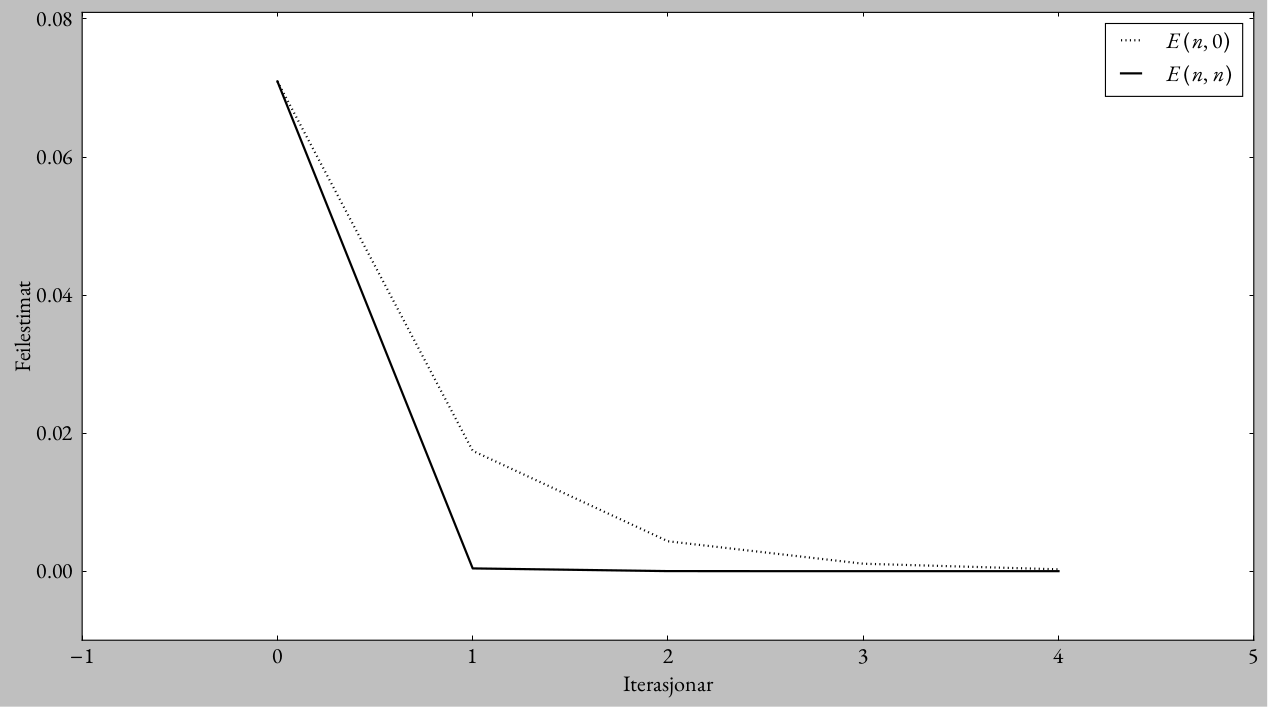

In [108]:
erf1, stats = romberg_collect_stats(gauss, 0, 1, tol=1e-9, exact=erf1_exact)

plt.plot(stats['En0'], 'k:', label="$E(n, 0)$")
plt.plot(stats['Enn'], 'k',  label="$E(n, n)$")

plt.xlabel("Iterasjonar")
plt.ylabel("Feilestimat")

plt.xlim(-1, len(stats['Enn']))
plt.ylim(-0.01, stats['Enn'][0] + 0.01)

plt.legend(loc="best")
plt.tight_layout()

Avviket $E(n, 0)$ svarar til finare og finare trapes-metode-kvadraturar.
$E(n, n)$ kovergerer vesentlig raskare, fordi den brukar informasjon om dei deriverte til funksjonen.